In [16]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [17]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_dataset = datasets.MNIST(root = '../dataset/mnist/',
                              train=True,
                              download = True,
                              transform = transform)
train_loader = DataLoader(train_dataset,
                         shuffle = True,
                         batch_size = batch_size)
test_dataset = datasets.MNIST(root = '../dataset/mnist/',
                             train = False,
                             download = True,
                             transform = transform)
test_loader = DataLoader(test_dataset,
                        shuffle = False,
                        batch_size = batch_size)

In [18]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.conv1 = torch.nn.Conv2d(channels,
                                     channels, 
                                     kernel_size = 3,
                                     padding = 1)
        self.conv2 = torch.nn.Conv2d(channels,
                                    channels,
                                    kernel_size = 3,
                                    padding = 1)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(x + y)

In [19]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size = 5)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size = 5)
        self.mp = torch.nn.MaxPool2d(2)
        
        self.rblock1 = ResidualBlock(16)
        self.rblock2 = ResidualBlock(32)
        
        self.fc = torch.nn.Linear(512, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(F.relu(self.conv1(x)))
        x = self.rblock1(x)
        x = self.mp(F.relu(self.conv2(x)))
        x = self.rblock2(x)
        x = x.view(in_size, -1)
        x = self.fc(x)
        return x

In [20]:
model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rblock1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (rblock2): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [21]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [22]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        
        #forward
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch +1, batch_idx +1, running_loss / 300))
            running_loss = 0.0

In [23]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim = 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        print('Accuracy on test set: %d %%' % (100 * correct / total))
    return 100 * correct / total

In [24]:
if __name__ == '__main__':
    correct = []
    for epoch in range(10):
        train(epoch)
        correct.append(test())


[1,   300] loss: 0.483
[1,   600] loss: 0.147
[1,   900] loss: 0.106
Accuracy on test set: 97 %
[2,   300] loss: 0.088
[2,   600] loss: 0.083
[2,   900] loss: 0.065
Accuracy on test set: 98 %
[3,   300] loss: 0.056
[3,   600] loss: 0.060
[3,   900] loss: 0.055
Accuracy on test set: 98 %
[4,   300] loss: 0.047
[4,   600] loss: 0.044
[4,   900] loss: 0.047
Accuracy on test set: 98 %
[5,   300] loss: 0.040
[5,   600] loss: 0.037
[5,   900] loss: 0.039
Accuracy on test set: 98 %
[6,   300] loss: 0.036
[6,   600] loss: 0.033
[6,   900] loss: 0.032
Accuracy on test set: 98 %
[7,   300] loss: 0.026
[7,   600] loss: 0.032
[7,   900] loss: 0.032
Accuracy on test set: 98 %
[8,   300] loss: 0.026
[8,   600] loss: 0.029
[8,   900] loss: 0.025
Accuracy on test set: 98 %
[9,   300] loss: 0.022
[9,   600] loss: 0.026
[9,   900] loss: 0.022
Accuracy on test set: 98 %
[10,   300] loss: 0.019
[10,   600] loss: 0.020
[10,   900] loss: 0.022
Accuracy on test set: 98 %


Text(0, 0.5, 'correct')

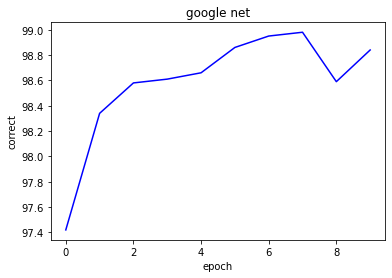

In [25]:
x = np.linspace(0,9,10)
correct = np.array(correct)
plt.plot(x, correct, c = 'b')
plt.title("google net")
plt.xlabel("epoch")
plt.ylabel("correct")